In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_files

In [116]:
from keras.preprocessing import image
from data_preprocessor.PreProcessImgData import PreProcessImgData

In [117]:
image_path_samples = '../train_camVid/*.png'
image_path_labels = '../LabeledApproved_full/*.png'
# image_path_samples = 'C:/Krishna/DataSets/cam_vid_semantic/train_samples/*.png'
# image_path_labels = 'C:/Krishna/DataSets/cam_vid_semantic/train_labels/*.png'

target_width = 256
target_height = 256
labels_dict = [[0, 0, 0],[128, 64, 128],[128, 0, 0]]
#labels_dict = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128], [128, 0, 128],[128,64,128]]
#labels_dict = [[128,64,128]]

In [118]:
p = PreProcessImgData(image_path_samples,
                      image_path_labels,
                      len(labels_dict), target_width, target_height, labels_dict)

sorted_samples = sorted(p.file_list_samples)
sorted_labels = sorted(p.file_list_labels)

In [119]:
from sklearn.model_selection import train_test_split

train_samples,test_samples,train_labels,test_labels = train_test_split(sorted_samples,sorted_labels,test_size=0.33, random_state=42)

In [120]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint


In [121]:
## Model for FCNNs with skip connections

img_input = Input(shape=(256,256,3))
conv1 = Conv2D(64,(3,3),activation= 'relu',padding='same')(img_input)
pool1 = MaxPool2D(pool_size=(2,2),padding='same')(conv1)

conv2 = Conv2D(128,(3,3),activation= 'relu',padding='same')(pool1)
pool2 = MaxPool2D(pool_size=(2,2),padding='same')(conv2)

conv3 = Conv2D(256,(3,3),activation= 'relu',padding='same')(pool2)
drop3 = Dropout(0.3)(conv3)
pool3 = MaxPool2D(pool_size=(2,2),padding='same')(drop3)

conv4 = Conv2D(512,(3,3),activation= 'relu',padding='same')(pool3)
drop4 = Dropout(0.3)(conv4)

# up_sample4 = UpSampling2D((2,2))(drop4)
# conv_transpose4 = Conv2DTranspose(512,(3,3),activation='relu',padding='same')(up_sample4)
# skip_connected_4 = Add()([conv_transpose4,drop4])

up_sample3 = UpSampling2D((2,2))(drop4)
conv_transpose3 = Conv2DTranspose(256,(3,3),activation='relu',padding='same')(up_sample3)
skip_connected_3 = Add()([conv_transpose3,drop3])

up_sample2 = UpSampling2D((2,2))(skip_connected_3)
conv_transpose2 = Conv2DTranspose(128,(3,3),activation='relu',padding='same')(up_sample2)
skip_connected_2 = Add()([conv_transpose2,conv2])

up_sample1 = UpSampling2D((2,2))(skip_connected_2)
conv_transpose1 = Conv2DTranspose(64,(3,3),activation='relu',padding='same')(up_sample1)
out_layer = Conv2D(len(labels_dict),(1,1),activation='softmax',padding='same')(conv_transpose1)


model = Model(input = img_input,output = out_layer)

model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 256, 256, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, 128, 128, 64) 0           conv2d_16[0][0]                  
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 128, 128, 128 73856       max_pooling2d_10[0][0]           
__________________________________________________________________________________________________
max_poolin

/home/aind2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [122]:
model.compile(optimizer = Adam(lr = 1e-3), loss = 'categorical_crossentropy', metrics = ['accuracy'])

Epoch 1/5
20/20 [==============================] - 91s 5s/step - loss: 0.9925 - acc: 0.4975
Epoch 2/5


/home/aind2/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:432: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


20/20 [==============================] - 90s 5s/step - loss: 0.7878 - acc: 0.5604
Epoch 3/5
20/20 [==============================] - 89s 4s/step - loss: 0.6129 - acc: 0.6817
Epoch 4/5
20/20 [==============================] - 90s 5s/step - loss: 0.5589 - acc: 0.7191
Epoch 5/5
20/20 [==============================] - 88s 4s/step - loss: 0.4712 - acc: 0.7839


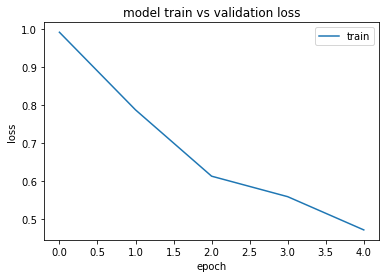

In [123]:
check_pointer = ModelCheckpoint('best_weights/best_weights.hdf5',verbose=1,save_best_only=True)
#history = model.fit(train_samples_array,train_labels_array,epochs=5,verbose=1,validation_split=0.1, batch_size=5,callbacks=[check_pointer])
history = model.fit_generator(p.train_generator(train_samples,train_labels,batch_size=32,test=False),
                              steps_per_epoch=20,epochs=5,verbose=1,callbacks=[check_pointer])

plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
# model.fit(train_samples_array,train_labels_array,epochs=5,verbose=2,batch_size=5,validation_split=0.2,callbacks=[check_pointer])

In [11]:
test_metrics = model.evaluate(test_samples_array,test_labels_array)
print(test_metrics)

NameError: name 'test_samples_array' is not defined

Epoch 1/5
20/20 [==============================] - 91s 5s/step - loss: 0.5094 - acc: 0.7567
Epoch 2/5


/home/aind2/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:432: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


20/20 [==============================] - 90s 4s/step - loss: 0.4849 - acc: 0.7844
Epoch 3/5
20/20 [==============================] - 90s 4s/step - loss: 0.4286 - acc: 0.8072
Epoch 4/5
20/20 [==============================] - 89s 4s/step - loss: 0.4085 - acc: 0.8175
Epoch 5/5
20/20 [==============================] - 90s 4s/step - loss: 0.3484 - acc: 0.8500


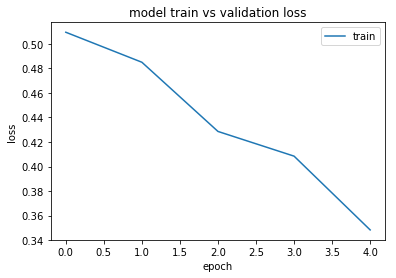

In [29]:
history = model.fit_generator(p.train_generator(train_samples,train_labels,batch_size=32,test=False),
                              steps_per_epoch=20,epochs=5,verbose=1,callbacks=[check_pointer])

plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Epoch 1/5
20/20 [==============================] - 93s 5s/step - loss: 0.3166 - acc: 0.8652
Epoch 2/5


/home/aind2/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:432: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


20/20 [==============================] - 89s 4s/step - loss: 0.3063 - acc: 0.8696
Epoch 3/5
20/20 [==============================] - 89s 4s/step - loss: 0.2896 - acc: 0.8776
Epoch 4/5
20/20 [==============================] - 90s 5s/step - loss: 0.2845 - acc: 0.8794
Epoch 5/5
20/20 [==============================] - 90s 5s/step - loss: 0.2598 - acc: 0.8912


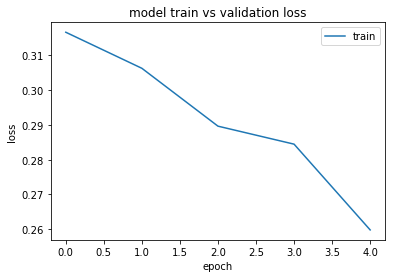

In [53]:
history = model.fit_generator(p.train_generator(train_samples,train_labels,batch_size=32,test=False),
                              steps_per_epoch=20,epochs=5,verbose=1,callbacks=[check_pointer])

plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [135]:
from PIL import Image

pred_array = model.predict(np.expand_dims(image.load_img(test_samples[100], target_size=(256, 256)),axis=0))


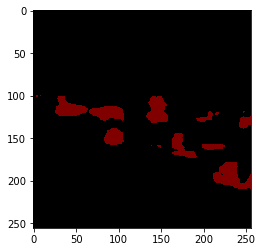

In [136]:
from matplotlib.pyplot import imshow

%matplotlib inline

pred_img = p.reduce_to_img(np.squeeze(pred_array))

imshow(Image.fromarray((pred_img).astype('uint8')))


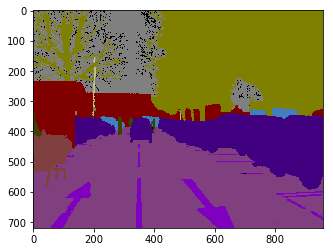

In [137]:
imshow(Image.open(test_labels[100]))

(256, 256, 3)


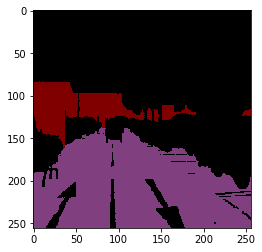

In [138]:
a = p.label_to_array(np.array(p.load(test_labels[100])))

print(a.shape)

lab_img = p.reduce_to_img(np.squeeze(a))

imshow(Image.fromarray((lab_img).astype('uint8')))

In [109]:
pred_array.shape

temp_img = p.reduce_to_img(np.squeeze(pred_array))
print(temp_img)

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


In [42]:
train_labels[150]

'../LabeledApproved_full/Seq05VD_f04950_L.png'